In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# constant variables
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 12

### Import data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "AgriculturalPest",
    shuffle=True,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE,
)

Found 5494 files belonging to 12 classes.


In [4]:
class_names = dataset.class_names
class_names

['ants',
 'bees',
 'beetle',
 'catterpillar',
 'earthworms',
 'earwig',
 'grasshopper',
 'moth',
 'slug',
 'snail',
 'wasp',
 'weevil']

### Visualize the Pest Images

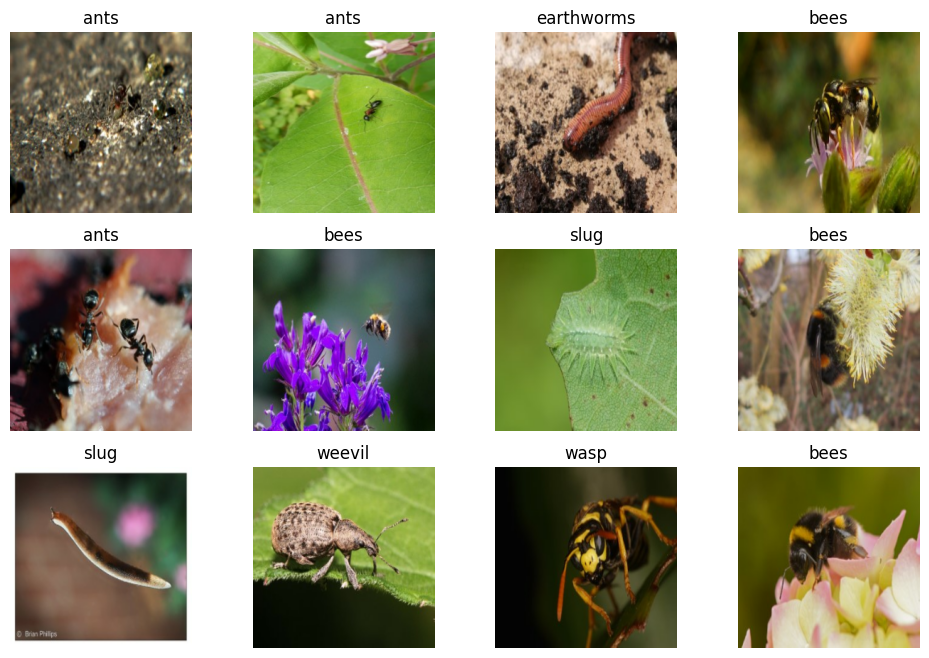

In [5]:
plt.figure(figsize=(12, 8))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

### Split dataset into Train Validation and Test

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

137 17 18


### Cache, Shuffle, and Prefetch the Dataset

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Data Augmentation

In [10]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1.0/255),
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomContrast(0.1),
])

In [11]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

In [12]:
# Function to visualize the accuracy and loss plots
def accuray_chart(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(range(EPOCHS), acc, label='Training Accuracy')
    plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(range(EPOCHS), loss, label='Training Loss')
    plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [13]:
# Function to run prediction on a sample image
def predict_by_model(model):
    for images_batch, labels_batch in test_ds.take(1):
        first_image = images_batch[0].numpy().astype('uint8')
        first_label = labels_batch[0]

        print('first image to predict')
        plt.imshow(first_image)
        plt.axis('off')
        print("first image's actual label:", class_names[first_label])

        batch_prediction = model.predict(images_batch)
        print("predicted label:", class_names[np.argmax(batch_prediction[0])])
    

## Training the Model 

### ResNet50V2 Model

In [14]:
# Load the pretrained ResNet50 Model
base_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
    pooling="avg"
)

# Freeze all layers in the base model
base_model.trainable = False

# Create the model
resnet_model = models.Sequential([
    augment,
    base_model,
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation='softmax')
])

resnet_model.build(input_shape=input_shape)
resnet_model.summary()

# Compile the model
resnet_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Train the model
resnet_history = resnet_model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (32, 128)                 262272    
                                                                 
 dropout (Dropout)           (32, 128)                 0         
                                                                 
 batch_normalization (BatchN  (32, 128)                512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (32, 64)                  8256      
                                                      

In [15]:
resnet_score = resnet_model.evaluate(test_ds)
print("    Test Loss: {:.5f}".format(resnet_score[0]))
print("Test Accuracy: {:.2f}%".format(resnet_score[1] * 100))

18/18 [==============================] - 42s 343ms/step - loss: 0.2148 - accuracy: 0.9427
    Test Loss: 0.21482
Test Accuracy: 94.27%


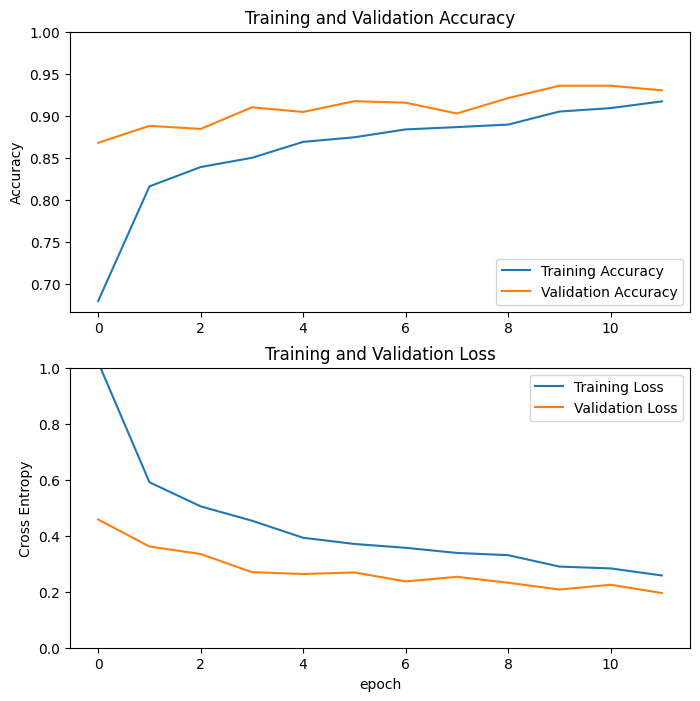

In [16]:
accuray_chart(resnet_history)

first image to predict
first image's actual label: weevil
1/1 [==============================] - 0s 41ms/step
predicted label: weevil


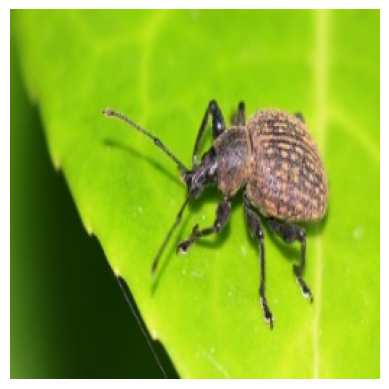

In [41]:
predict_by_model(resnet_model)

### MobileNet Model

In [18]:
# Load the pretrained MobileNet Model
base_model = tf.keras.applications.mobilenet.MobileNet(
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
    pooling="avg"
)

# Freeze all layers in the base model
base_model.trainable = False

# Create the model
mobilenet_model = models.Sequential([
    augment,
    base_model,
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.45),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation='softmax')
])

mobilenet_model.build(input_shape=input_shape)
mobilenet_model.summary()

# Compile the model
mobilenet_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Train the model
mobilenet_history = mobilenet_model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 1024)             3228864   
 nal)                                                            
                                                                 
 dense_3 (Dense)             (32, 128)                 131200    
                                                                 
 dropout_2 (Dropout)         (32, 128)                 0         
                                                                 
 batch_normalization_1 (Batc  (32, 128)                512       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (32, 256)                

In [19]:
mobilenet_score = mobilenet_model.evaluate(test_ds)
print("    Test Loss: {:.5f}".format(mobilenet_score[0]))
print("Test Accuracy: {:.2f}%".format(mobilenet_score[1] * 100))

18/18 [==============================] - 5s 258ms/step - loss: 0.3847 - accuracy: 0.8872
    Test Loss: 0.38470
Test Accuracy: 88.72%


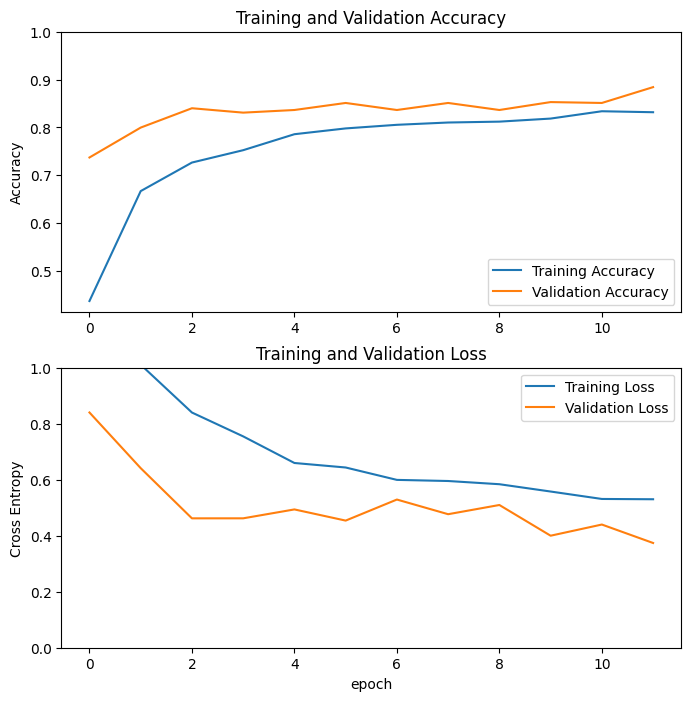

In [20]:
accuray_chart(mobilenet_history)

first image to predict
first image's actual label: snail
1/1 [==============================] - 1s 947ms/step
predicted label: snail


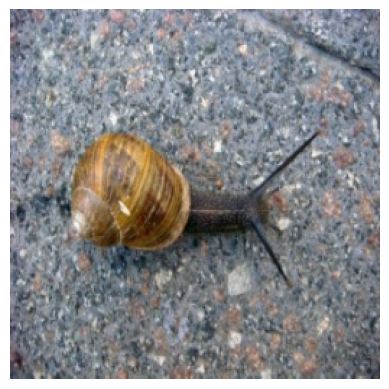

In [21]:
predict_by_model(mobilenet_model)

### InceptionV3 Model 

In [22]:
# Load the pretrained InceptionV3 Model
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
    pooling="max"
)

# Freeze all layers in the base model
base_model.trainable = False

# Create the model
inception_model = models.Sequential([
    augment,
    base_model,
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation='softmax')
])

inception_model.build(input_shape=input_shape)
inception_model.summary()

# Compile the model
inception_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Train the model
inception_history = inception_model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense_7 (Dense)             (32, 128)                 262272    
                                                                 
 dropout_5 (Dropout)         (32, 128)                 0         
                                                                 
 batch_normalization_96 (Bat  (32, 128)                512       
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (32, 64)                  8256      
                                                      

In [23]:
inception_score = inception_model.evaluate(test_ds)
print("    Test loss: {:.5f}".format(inception_score[0]))
print("Test Accuracy: {:.2f}%".format(inception_score[1] * 100))

18/18 [==============================] - 6s 332ms/step - loss: 0.3908 - accuracy: 0.8767
    Test Loss: 0.39083
Test Accuracy: 87.67%


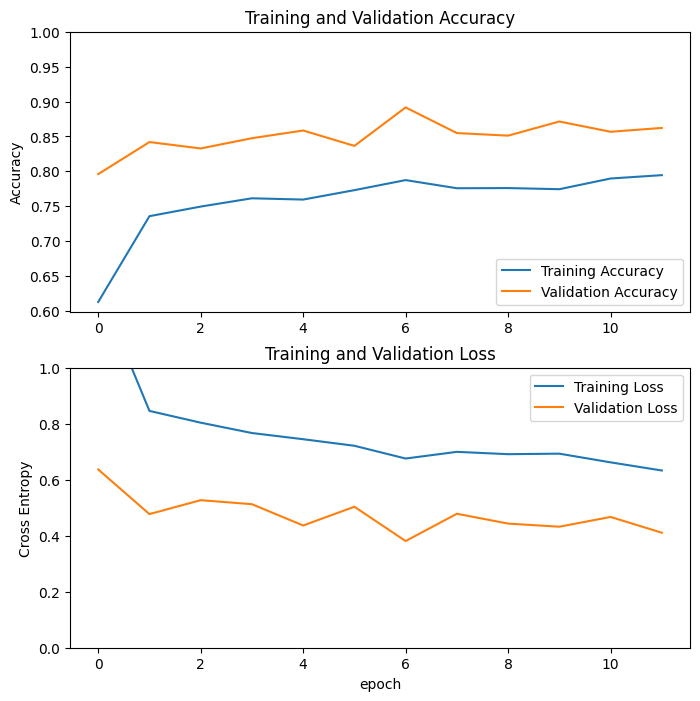

In [24]:
accuray_chart(inception_history)

first image to predict
first image's actual label: weevil
1/1 [==============================] - 2s 2s/step
predicted label: weevil


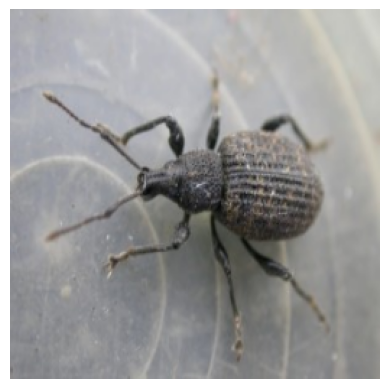

In [25]:
predict_by_model(inception_model)

### DenseNet121 Model

In [26]:
# Load the pretrained DenseNet121 Model
base_model = tf.keras.applications.DenseNet121(
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
    pooling="max"
)

# Freeze all layers in the base model
base_model.trainable = False

# Create the model
densenet_model = models.Sequential([
    augment,
    base_model,
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation='softmax')
])

densenet_model.build(input_shape=input_shape)
densenet_model.summary()

# Compile the model
densenet_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Train the model    
densenet_history = densenet_model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 dense_10 (Dense)            (32, 128)                 131200    
                                                                 
 dropout_7 (Dropout)         (32, 128)                 0         
                                                                 
 batch_normalization_97 (Bat  (32, 128)                512       
 chNormalization)                                                
                                                                 
 dense_11 (Dense)            (32, 64)                  8256      
                                                      

In [27]:
densenet_score = densenet_model.evaluate(test_ds)
print("Test Loss: {:.5f}".format(densenet_score[0]))
print("Test Accuracy: {:.2f}%".format(densenet_score[1] * 100))

18/18 [==============================] - 9s 512ms/step - loss: 0.2919 - accuracy: 0.9080
    Test Loss: 0.29187
Test Accuracy: 90.80%


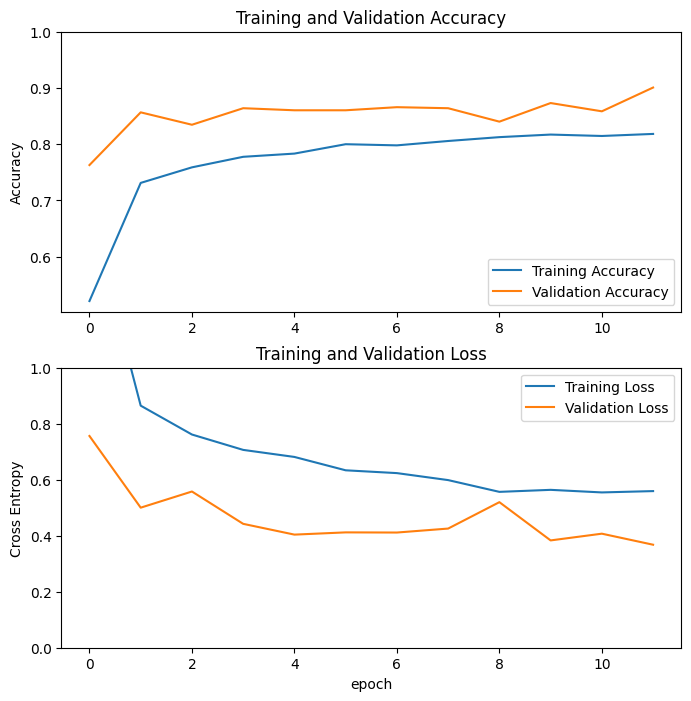

In [28]:
accuray_chart(densenet_history)

first image to predict
first image's actual label: bees
1/1 [==============================] - 4s 4s/step
predicted label: bees


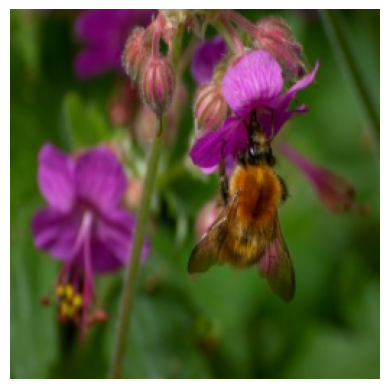

In [29]:
predict_by_model(densenet_model)

## Evaluation and prediction

### Compare Models Accuracy

In [30]:
pd.DataFrame({'Model': ['ResNet50V2', 'MobileNet', 'InceptionV3', 'DenseNet121'], 
            'Accuracy': [resnet_score[1]*100, mobilenet_score[1]*100, inception_score[1]*100, densenet_score[1]*100]}).sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
0,ResNet50V2,94.270831
3,DenseNet121,90.798610
1,MobileNet,88.715279
2,InceptionV3,87.673610


### Making predictions on the Test Data

In [31]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

In [32]:
def model_prediction(model):
    plt.figure(figsize=(12,13))
    for images, labels in test_ds.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis('off')

1/1 [==============================] - 0s 71ms/step


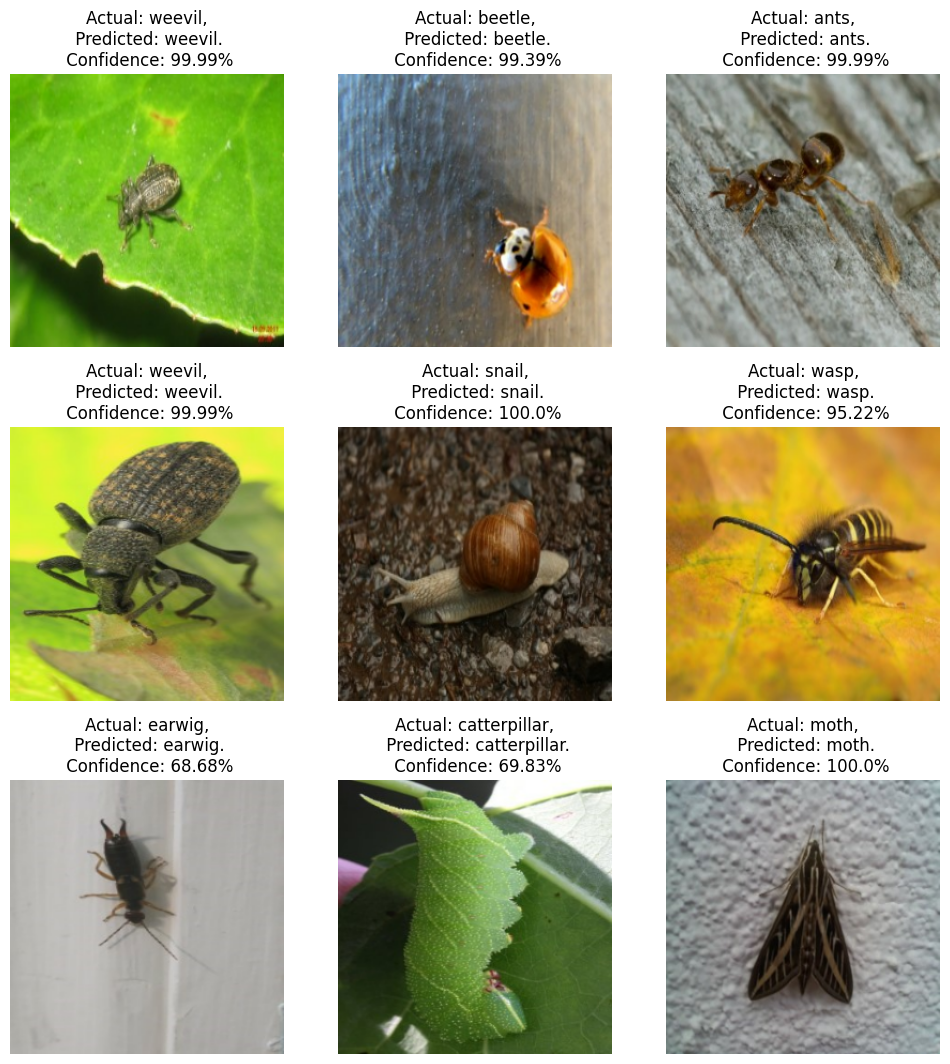

In [33]:
models=[resnet_model, mobilenet_model, inception_model, densenet_model]
highest_accuracy_model = models[np.argmax([resnet_score[1], mobilenet_score[1], inception_score[1], densenet_score[1]])]
model_prediction(highest_accuracy_model)